Based on the 'activation maximization' technique suggested in [this](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf) paper. 

We will view the layers of the (pretrained) GoogLeNet just like in [this](https://distill.pub/2017/feature-visualization/) post.

## Import useful libraries 

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models

## Import a pretrained GoogLeNet

In [5]:
model = models.googlenet(pretrained = True)

model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [6]:
# We now freeze the parameters of our pretrained model
for param in model.parameters():
    param.requires_grad_(False)

In [7]:
# layer: inception4a
model.inception4a

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(480, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(96, 208, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(208, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(480, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): Batc

In [8]:
# We will register a forward hook to get the output of the layers

activation = {} # to store the activation  of a layer
def create_hook(name):
    def hook(m, i, o):
        # copy the output of the given layer
        activation[name] = o
       
    return hook


# register a forward hook for layer 3a i.e. the first inception layer
model.inception4a.register_forward_hook(create_hook('4a'))

## Create an input image 

The starting image will consist of random values for the pixels

In [9]:
# normalize the input image to have appropriate mean and standard deviation as specified by pytorch
from torchvision import transforms



normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [15]:
from torch import optim

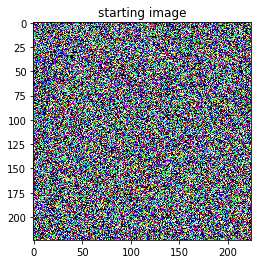

In [12]:
# function to massage img_tensor for using as input to plt.imshow()
def image_converter(im):
    
    # move the image to cpu
    im_copy = im.cpu()
    
    # for plt.imshow() the channel-dimension is the last
    # therefore use transpose to permute 
    im_copy = im_copy.clone().detach().numpy().transpose(1,2,0)
    # clip negative values as plt.imshow() only accepts 
    # floating values in range [0,1] and integers in range [0,255]
    im_copy = im_copy.clip(0, 1) 
    
    return im_copy

plt.imshow(image_converter(img_tensor))                                                               
plt.title('starting image')
plt.show()

In [9]:
# generating the initial image with random pixel values between 0 and 1
H = 224 # height of input image
W = 224 # width of input image
img = np.single(np.random.uniform(0,1, (3, H, W))) # we need the pixel values to be of type float32 hence np.single 
print("img_shape:{}, img_dtype: {}".format(img.shape, img.dtype ))
# convert the image to a torch tensor with the requisite mean and std. dev. 
img_tensor = normalize(torch.from_numpy(img))
print(img_tensor)

img_shape:(3, 224, 224), img_dtype: float32
tensor([[[ 0.0132,  2.0459, -1.3980,  ...,  0.4871,  0.0241,  0.4791],
         [-0.6418, -0.1801, -0.2546,  ...,  1.3750,  0.7137, -1.4458],
         [ 1.8584,  0.4409, -0.5231,  ...,  2.1609, -1.2404,  1.7606],
         ...,
         [-0.3137, -1.8583, -1.8597,  ..., -1.6711, -0.8638, -0.4706],
         [ 2.1128, -0.8442, -1.5413,  ...,  1.6433,  1.3343,  1.8194],
         [-0.1082, -0.4401, -0.2541,  ..., -1.0467, -0.3265,  1.3970]],

        [[-1.0733,  2.0348, -0.8736,  ...,  0.6549,  2.2871,  0.0592],
         [ 2.1937, -1.9766,  1.4216,  ...,  0.4476,  1.5163, -1.3695],
         [ 1.3034, -1.2306,  0.7855,  ..., -1.6867,  0.1884,  1.0756],
         ...,
         [-1.5891,  1.8968,  1.5855,  ..., -0.1056,  0.7680, -0.1451],
         [-0.4989, -0.6692, -1.2849,  ..., -1.0814, -1.5028, -0.4064],
         [ 2.1575,  1.8675, -0.4445,  ..., -1.8808,  2.2385, -1.8414]],

        [[-1.1833, -0.1708,  0.5818,  ...,  1.4562,  2.5533,  2.1683],
 

In [13]:
# move the model and input image to the GPU (if available) 
# This should be done before defining an optimizer
# This is mentioned in the following pytorch page: https://pytorch.org/docs/master/optim.html
# Also see the discussion here: https://discuss.pytorch.org/t/effect-of-calling-model-cuda-after-constructing-an-optimizer/15165/7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Calculations being executed on {}'.format(device))

model.to(device)
img_tensor = img_tensor.to(device).requires_grad_(True) # move the image tensor to cuda 
                                                        # set its requires_grad_ flag to be true

# check that the model and img_tensor are on cuda or not
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
print('googlenet is on cuda: {}'.format(next(model.parameters()).is_cuda))
print('img_tensor is on cuda: {}'.format(img_tensor.is_cuda))

optimizer = optim.Adam([img_tensor], lr = 0.01)

Calculations being executed on cuda
googlenet is on cuda: True
img_tensor is on cuda: True


epoch: 0/10000, activation: 0.00817894283682108


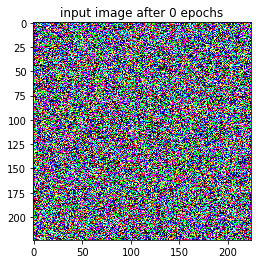

epoch: 1000/10000, activation: 33.10124969482422


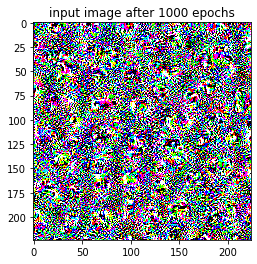

epoch: 2000/10000, activation: 59.27873611450195


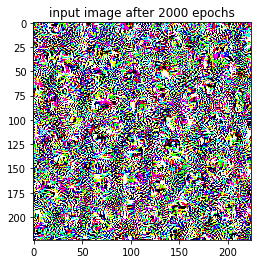

epoch: 3000/10000, activation: 85.50870513916016


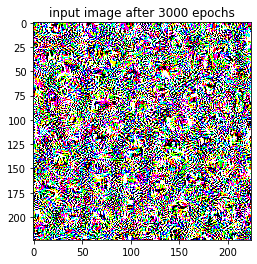

epoch: 4000/10000, activation: 111.9630355834961


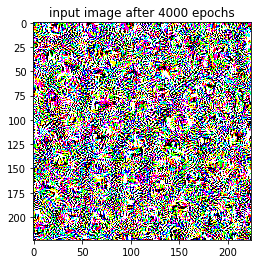

epoch: 5000/10000, activation: 138.4989471435547


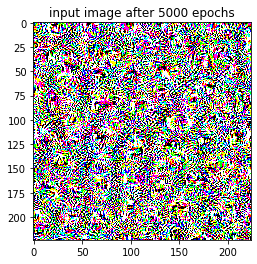

epoch: 6000/10000, activation: 165.0849151611328


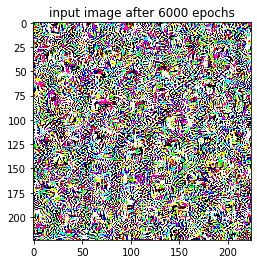

epoch: 7000/10000, activation: 191.74253845214844


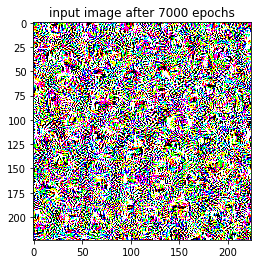

epoch: 8000/10000, activation: 218.5726776123047


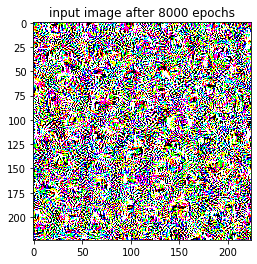

epoch: 9000/10000, activation: 245.57359313964844


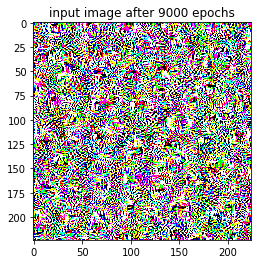

In [14]:
# Since we are not training googlenet here, therefore we should use evaluation mode 
# this is because batch-normalization layers in googlenet will have different behaviour in traning vs evaluation modes
model.eval()


num_epochs = 10000
display_every = 1000
unit_idx = 11 # unit of the convolution layer that we wish to visualize

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    model(img_tensor.unsqueeze(0))
    layer_out = activation['4a']
    loss = -layer_out[0, unit_idx].mean() 
    loss.backward()
    optimizer.step()
    # normalize the updated img_tensor to have pytorch specified mean and std. dev.
    # img_tensor = normalize(img_tensor.clone().detach()).requires_grad_(True)
    # the above step of renormalizing the updated img_tensor does not work: the activation remains frozen at ~ 2.368 and no patterns seem to develop in the image
    # Will have to understand this further  
    
    if epoch % display_every == 0:
        print('epoch: {}/{}, activation: {}'.format(epoch, num_epochs, -loss))
        plt.imshow(image_converter(img_tensor))
        plt.title('input image after {} epochs'.format(epoch))
        plt.show()


The final image does seeem to have some very high frequency patterns. However, the high frequency behaviour obscures any interpretation of what the neuron seems to learning. 

I found that my code above is quite similar to the implementation of feature visualization with activation maximization in [this](https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030) blog post. There the author also discusses the emerges of high frequence patterns in the image and how he got around it by initially feeding smaller sized images and slowing upscaling them. Let us try this.

In [18]:
upscaling_steps = 12 # no. of times to upscale
upscaling_factor = 1.2
optim_steps = 10000 # no. of times to optimize an input image before upscaling

In [16]:
import cv2 # for resizing images

# e.g. of how to resize images using cv2
# just like in plt.imshow() cv2 also expects the channel info. to be in the last axis
# the documentation for cv2.resize() recommends using inter_cubic for interpolation when upscaling
cv2.resize(image_converter(img_tensor), dsize = (0,0) , fx = upscaling_factor, fy = upscaling_factor, 
           interpolation = cv2.INTER_CUBIC).shape 

(269, 269, 3)

In [ ]:
# move the model to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Calculations being executed on {}'.format(device))

model.to(device)

In [17]:
# initial random image
H = 28 # height of image
W = 28 # width of image
im = np.single(np.random.uniform(0, 1, (3, H, W))) # we need the pixel values to be of type float32 
img_tensor = normalize(torch.from_numpy(im)).to(device).requires_grad_(True)
print('image shape: {}, device: {}, dtype: {}'.format(img_tensor.shape, 
                                                      img_tensor.device, img_tensor.dtype ))

# check that the model and img_tensor are on cuda or not
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
print('googlenet is on cuda: {}'.format(next(model.parameters()).is_cuda))
print('img_tensor is on cuda: {}'.format(img_tensor.is_cuda))

optimizer = optim.Adam([img_tensor], lr = 0.01)

image shape: torch.Size([3, 28, 28]), device: cuda:0, dtype: torch.float32


begin mag_epoch 0, activation: 0.40968644618988037
end mag_epoch: 0, activation: 11983.181640625


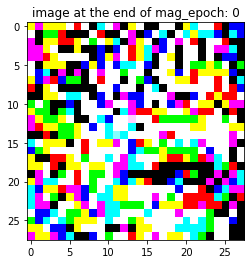

begin mag_epoch 1, activation: 0.05806637555360794
end mag_epoch: 1, activation: 9839.447265625


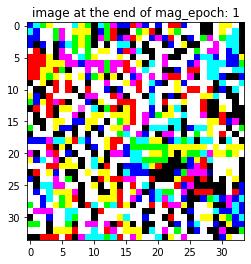

begin mag_epoch 2, activation: 0.8577280044555664
end mag_epoch: 2, activation: 12900.45703125


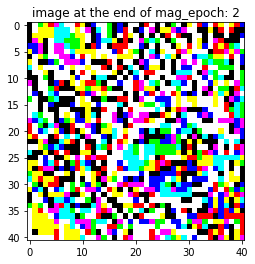

begin mag_epoch 3, activation: 0.310092568397522
end mag_epoch: 3, activation: 10722.435546875


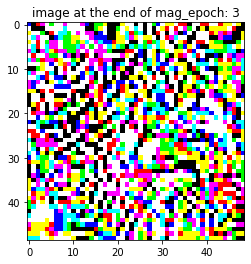

begin mag_epoch 4, activation: 0.12469574064016342
end mag_epoch: 4, activation: 13504.1328125


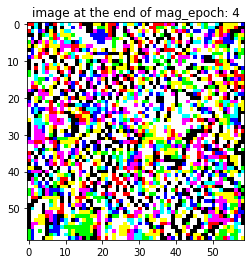

begin mag_epoch 5, activation: 0.17147715389728546
end mag_epoch: 5, activation: 12740.734375


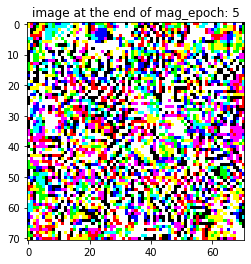

begin mag_epoch 6, activation: 0.09877409040927887
end mag_epoch: 6, activation: 13182.4951171875


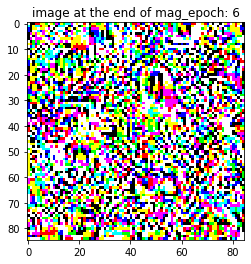

begin mag_epoch 7, activation: 0.25619280338287354
end mag_epoch: 7, activation: 13356.216796875


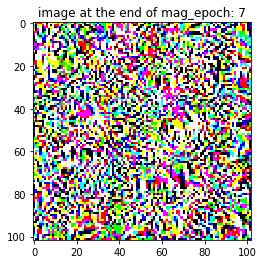

begin mag_epoch 8, activation: 0.14659912884235382
end mag_epoch: 8, activation: 12880.9453125


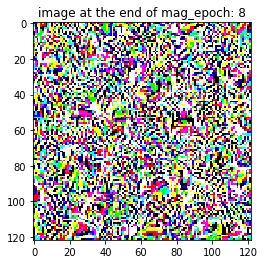

begin mag_epoch 9, activation: 0.09225565195083618
end mag_epoch: 9, activation: 13198.0771484375


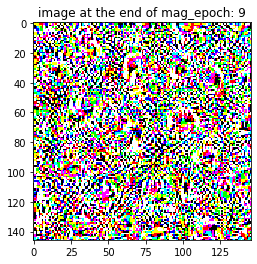

begin mag_epoch 10, activation: 0.1496267467737198
end mag_epoch: 10, activation: 12601.8857421875


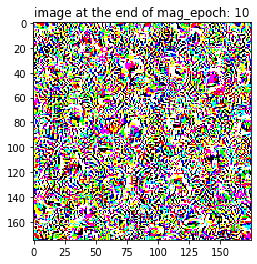

begin mag_epoch 11, activation: 0.07510879635810852
end mag_epoch: 11, activation: 12478.3525390625


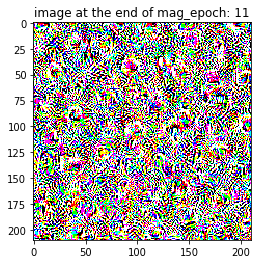

In [19]:
unit_idx = 11 # the neuron to visualize

model.eval()
for mag_epoch in range(upscaling_steps):
    optimizer = optim.Adam([img_tensor], lr = 0.4)
    
    for opt_epoch in range(optim_steps):
        optimizer.zero_grad()
        model(img_tensor.unsqueeze(0))
        layer_out = activation['4a']
        loss = -layer_out[0, unit_idx].mean()
        # print activation at the beginning of each mag_epoch
        if opt_epoch == 0:
            print('begin mag_epoch {}, activation: {}'.format(mag_epoch, -loss))
        loss.backward()
        optimizer.step()
        
    # view the result of optimising the image
    print('end mag_epoch: {}, activation: {}'.format(mag_epoch, -loss))
    img = image_converter(img_tensor)    
    plt.imshow(img)
    plt.title('image at the end of mag_epoch: {}'.format(mag_epoch))
    plt.show()
    
    img = cv2.resize(img, dsize = (0,0), 
                     fx = upscaling_factor, fy = upscaling_factor).transpose(2,0,1) # scale up and move the batch axis to be the first
    img_tensor = torch.from_numpy(img).to(device).requires_grad_(True)

In [20]:
img_tensor.shape

torch.Size([3, 252, 252])

Simply scaling up the image slowly does not seem ameliorate the issue :(

In my experiments so far, I had defined activation of a unit to be the average of the elements in the output tensor of that unit. Loss was then defined to be the negative of this activation. Let me consider a new definition of activation: root-mean-squared value of the elements in the output tensor.

In [10]:
# generating the initial image with random pixel values between 0 and 1
H = 224 # height of input image
W = 224 # width of input image
img = np.single(np.random.uniform(0,1, (3, H, W))) # we need the pixel values to be of type float32 hence np.single 
print("img_shape:{}, img_dtype: {}".format(img.shape, img.dtype ))
# convert the image to a torch tensor with the requisite mean and std. dev. 
img_tensor = normalize(torch.from_numpy(img))
print(img_tensor)

img_shape:(3, 224, 224), img_dtype: float32
tensor([[[-1.8282e+00,  1.5211e-01,  1.1949e+00,  ..., -1.3892e+00,
           5.1293e-01,  1.5253e+00],
         [-2.0505e+00,  1.3352e+00,  2.2240e+00,  ...,  8.3784e-01,
          -2.7251e-01, -4.8015e-01],
         [ 3.0708e-01, -2.2864e-01, -9.9247e-02,  ...,  5.8393e-01,
          -1.5236e+00,  5.9711e-01],
         ...,
         [ 1.1217e+00,  4.1725e-01, -1.9073e+00,  ...,  1.7037e+00,
          -7.4728e-01, -1.8934e+00],
         [ 1.5415e-01, -4.3231e-01,  6.8094e-01,  ...,  8.5331e-01,
          -1.3161e+00,  1.4863e+00],
         [ 5.6692e-01, -1.9632e+00,  1.9595e+00,  ..., -1.1194e+00,
          -4.1253e-01, -1.7721e+00]],

        [[-1.3740e+00, -3.9026e-01, -7.8007e-01,  ...,  1.7017e+00,
           5.1463e-01,  2.0632e+00],
         [-7.0227e-02, -1.6406e+00,  3.5847e-01,  ..., -1.4603e+00,
           9.1936e-01,  2.2102e+00],
         [ 1.5839e+00, -1.6579e+00,  1.0069e-01,  ...,  4.8814e-02,
           4.1564e-04,  1.3972e+

In [16]:
# move the model and input image to the GPU (if available) 
# This should be done before defining an optimizer
# This is mentioned in the following pytorch page: https://pytorch.org/docs/master/optim.html
# Also see the discussion here: https://discuss.pytorch.org/t/effect-of-calling-model-cuda-after-constructing-an-optimizer/15165/7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Calculations being executed on {}'.format(device))

model.to(device)
img_tensor = img_tensor.to(device).requires_grad_(True) # move the image tensor to cuda 
                                                        # set its requires_grad_ flag to be true

# check that the model and img_tensor are on cuda or not
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
print('googlenet is on cuda: {}'.format(next(model.parameters()).is_cuda))
print('img_tensor is on cuda: {}'.format(img_tensor.is_cuda))

optimizer = optim.Adam([img_tensor], lr = 0.01)

Calculations being executed on cuda
googlenet is on cuda: True
img_tensor is on cuda: True


epoch: 0/10000, activation: 0.059695057570934296


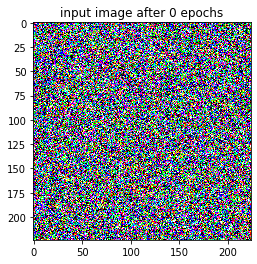

epoch: 1000/10000, activation: 32.88395690917969


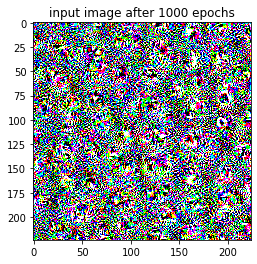

epoch: 2000/10000, activation: 56.95502853393555


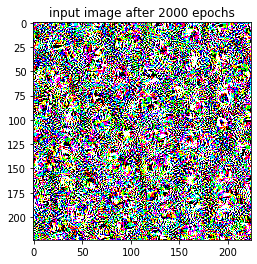

epoch: 3000/10000, activation: 82.25138092041016


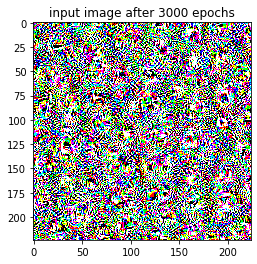

epoch: 4000/10000, activation: 108.02877044677734


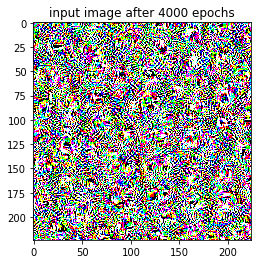

epoch: 5000/10000, activation: 133.62562561035156


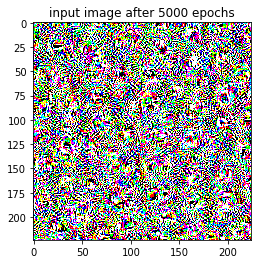

epoch: 6000/10000, activation: 159.20310974121094


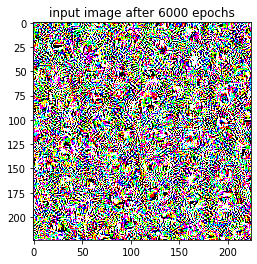

epoch: 7000/10000, activation: 184.90745544433594


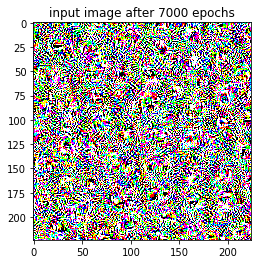

epoch: 8000/10000, activation: 210.82015991210938


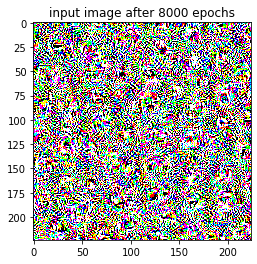

epoch: 9000/10000, activation: 236.8733673095703


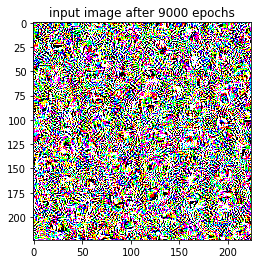

In [18]:
# Since we are not training googlenet here, therefore we should use evaluation mode 
# this is because batch-normalization layers in googlenet will have different behaviour in traning vs evaluation modes
model.eval()


num_epochs = 10000
display_every = 1000
unit_idx = 11 # unit of the convolution layer that we wish to visualize

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    model(img_tensor.unsqueeze(0))
    layer_out = activation['4a']
    rms = torch.pow(torch.pow(layer_out[0, unit_idx],2).mean(), 0.5)
    loss = - rms
    loss.backward()
    optimizer.step()
    # normalize the updated img_tensor to have pytorch specified mean and std. dev.
    # img_tensor = normalize(img_tensor.clone().detach()).requires_grad_(True)
    # the above step of renormalizing the updated img_tensor does not work: the activation remains frozen at ~ 2.368 and no patterns seem to develop in the image
    # Will have to understand this further  
    
    if epoch % display_every == 0:
        print('epoch: {}/{}, activation: {}'.format(epoch, num_epochs, -loss))
        plt.imshow(image_converter(img_tensor))
        plt.title('input image after {} epochs'.format(epoch))
        plt.show()

This does not help either!